# Classification with Random Forest Classifier  

After cleaning and analysing the dataset we proceed with a classifier, which is carried on with the random forest classifier algorithm

![random-forest.jpg](random-forest.jpg)

## Preparing the data 

We import the relevant libraries from ScikitLearn

In [38]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

We import the data from `TWER_grouped_class.csv`:

In [98]:
df = pd.read_csv('../data/processed/TWER_grouped_class.csv').drop('Unnamed: 0', axis=1)

In [99]:
df.head()

,date,municipality.name,hour_category,temperature,minTemperature,maxTemperature,precipitation,wind_speed,wind_dir,curr_cell,curr_site,population,elevation,tweet_count,month,day,day_of_week,class
0,2013-11-01,Andalo,A,9.200000,8.5,12.000000,0.0,NaN,NaN,0.000000,0.000000,1024.0,1042.0,1,11,1,4,Low
1,2013-11-01,Baselga di Pinè,B,11.533333,8.0,13.733333,0.0,0.2,236.0,5.996413,0.016458,4928.0,964.0,3,11,1,4,Medium
2,2013-11-01,Baselga di Pinè,C,11.433333,7.3,12.966667,0.0,0.0,184.0,10.637787,0.017426,4928.0,964.0,3,11,1,4,Medium
3,2013-11-01,Baselga di Pinè,D,9.350000,6.6,12.200000,0.0,NaN,NaN,18.809585,0.024556,4928.0,964.0,2,11,1,4,Medium
4,2013-11-01,Bedollo,B,14.120000,8.7,14.500000,0.0,0.3,232.5,0.383955,0.015358,1476.0,1059.0,5,11,1,4,Medium


Before continuing, we need to remove the last day (2013-12-31), on which we will make the prediction.

In [100]:
df = df[df['day'] != 31]

Let's divide `df` into features and target:

In [101]:
X = df.drop('class', axis=1)
y = df['class']  # target is the multi-class label (High, Medium, Low)

We now preprocess the data. 
The classifier only really accepts numbers as an input, so string-to-number conversion of categorical data is essential.
Since this process only concerns categorical data,  we need to split numerical and categorical features first. 

In [102]:
X.columns

Index(['date', 'municipality.name', 'hour_category', 'temperature',
       'minTemperature', 'maxTemperature', 'precipitation', 'wind_speed',
       'wind_dir', 'curr_cell', 'curr_site', 'population', 'elevation',
       'tweet_count', 'month', 'day', 'day_of_week'],
      dtype='object')

In [103]:
categorical_features = ['date', 'municipality.name', 'hour_category', 'month', 'day_of_week']  # Any string or categorical features
numerical_features = ['temperature', 
                      'minTemperature', 
                      'maxTemperature', 
                      'precipitation', 
                      'wind_speed',
                      'wind_dir',
                      'curr_cell',
                      'population',
                      'elevation',
                      'curr_site',
                      'tweet_count',
                      'day']

Second, we enconde the categorical data with label encoding. 

In [104]:
le = LabelEncoder()
for feat in categorical_features:
    X[feat] = le.fit_transform(X[feat])

In [105]:
X[categorical_features].head()

,date,municipality.name,hour_category,month,day_of_week
0,0,4,0,0,4
1,0,6,1,0,4
2,0,6,2,0,4
3,0,6,3,0,4
4,0,7,1,0,4


We then scale the numerical features, convert them back to dataframe form and finally recombine categorical and numerical data 

In [106]:
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(X[numerical_features])

In [107]:
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_features)

In [108]:
X = pd.concat([scaled_numerical_df, X[categorical_features].astype('category')], axis=1)

In [109]:
X.head()

,temperature,minTemperature,maxTemperature,precipitation,wind_speed,wind_dir,curr_cell,population,elevation,curr_site,tweet_count,day,date,municipality.name,hour_category,month,day_of_week
0,1.359660,2.083997,1.183481,-0.236583,NaN,NaN,-0.547011,-0.368773,0.952868,-0.358125,-0.403790,-1.760071,0,4,0,0,4
1,1.910475,1.960059,1.636554,-0.236583,-0.806376,0.438802,-0.212064,-0.211177,0.742049,-0.254979,-0.225732,-1.760071,0,6,1,0,4
2,1.886869,1.786544,1.436156,-0.236583,-0.990016,-0.104575,0.047193,-0.211177,0.742049,-0.248914,-0.225732,-1.760071,0,6,2,0,4
3,1.395069,1.613030,1.235759,-0.236583,NaN,NaN,0.503653,-0.211177,0.742049,-0.204231,-0.314761,-1.760071,0,6,3,0,4
4,2.521093,2.133573,1.836952,-0.236583,-0.714557,0.402229,-0.525564,-0.350527,0.998816,-0.261873,-0.047674,-1.760071,0,7,1,0,4


This is now a dataframe we can work with. 

Now we prepare for the regression by splitting Train Data and Test Data. 
We want the test data to be the 20% of the data available (test_size=0.2) and we want to fix a random_state value of 20. 

This is basically like a seed and assures the "random behaviour" of the forest, to be always the same if we run the program the program multiple times. 

In the fase of tuning repeatability is essential, because it is the only way to reliably tune the parameters of the model. 

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

We initialise and train the Random Forest Classifier. 
We initialise it to a pretty canonical number of estimators (100) and to the already mentioned random_state=20.  
We don't use a max_depth parameter since the completion of the random forest's training is very fast.

In [111]:
# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=20)

In [112]:
# Train the classifier
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=20)

Eventually, we obtain a prediction on the data 

In [113]:
y_pred = rf_classifier.predict(X_test)

We calculate here some meaningful extimators 

In [114]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9989743589743589
              precision    recall  f1-score   support

        High       1.00      0.97      0.99        37
         Low       1.00      1.00      1.00       441
      Medium       1.00      1.00      1.00       497

    accuracy                           1.00       975
   macro avg       1.00      0.99      1.00       975
weighted avg       1.00      1.00      1.00       975



We notice the accuracy is really close to 1, which indicates the goodness of the described model. 
It is then a good idea to plot a confusion matrix and a heatmap to see what points have been misclassified.

[Text(0, 0.5, 'high'), Text(0, 1.5, 'low'), Text(0, 2.5, 'medium')]

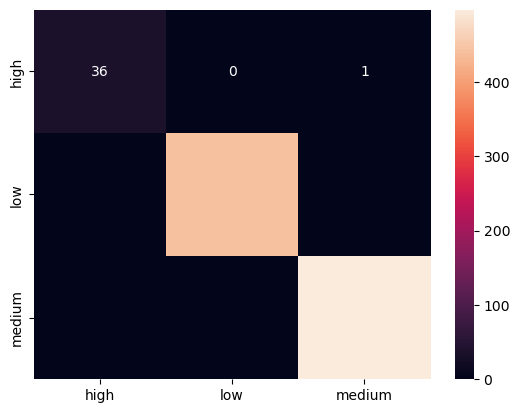

In [115]:
confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', ax=ax)
ax.xaxis.set_ticklabels(['high', 'low', 'medium'])
ax.yaxis.set_ticklabels(['high', 'low', 'medium'])

The remarkable fact is that just 1 point has been misclassified . 

This prediction is possible with a particular choice of the dataset. 

The only set of features that appears to be relevant is that related to the weather, and indeed the changing of the classifier's random_state variable does not alter this fact.

The strongest predictor for tweet count is arguably temperature, that is evident by seeing at the plot which is available in the EDA notebook.

We noticed that some features as month, day, day of the week and electrical data, actually worsen the model. More values are in fact mispredicted.
The error is always the same, some municipalities, which are predicted to be in the middle tweet count range, actually end up to be in the high tweet count range. 

This makes sense, because, whereas there are not many events outside our dataset which can cause great short term depression in the tweet count, there are lots of social events that may cause an occasional peak in the tweet count. 
In the dates 13 and 14 Decembers 2013, which present the greatest tweet predictive mistake, a big event called "Universiadi " was held in the municipality of Trento, where such peak is registered. 

If we insert those data, we have a bigger variance because we enlarge the model with data which is not significantly correlated.
We may be experimenting an overfitting phenomenon, increasing the features of the data requires increasing information to effectively model patterns without overfitting.
If the mentioned data are not higly informative, and our EDA results suggest precisely that, we can very well incur in this overfitting problem.  




## Model with only weather:

In [54]:
X = df.drop('class', axis=1).drop(['curr_cell', 'curr_site', 'population', 'elevation'], axis=1)
y = df['class']  # target is the multi-class label (High, Medium, Low)

In [55]:
categorical_features = ['date', 'municipality.name', 'hour_category', 'month', 'day_of_week']  # Any string or categorical features
numerical_features = ['temperature', 
                      'minTemperature', 
                      'maxTemperature', 
                      'precipitation', 
                      'wind_speed',
                      'wind_dir',
                      'tweet_count',
                      'day']

In [56]:
le = LabelEncoder()
for feat in categorical_features:
    X[feat] = le.fit_transform(X[feat])

In [57]:
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(X[numerical_features])

In [58]:
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_features)

In [59]:
X = pd.concat([scaled_numerical_df, X[categorical_features].astype('category')], axis=1)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [66]:
# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=4, random_state=20)

In [67]:
# Train the classifier
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=4, random_state=20)

In [68]:
y_pred = rf_classifier.predict(X_test)

In [69]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9958974358974358
              precision    recall  f1-score   support

        High       0.97      0.92      0.94        37
         Low       1.00      1.00      1.00       441
      Medium       0.99      1.00      1.00       497

    accuracy                           1.00       975
   macro avg       0.99      0.97      0.98       975
weighted avg       1.00      1.00      1.00       975



We notice the accuracy is really close to 1, which indicates the goodness of the described model. 
It is then a good idea to plot a confusion matrix and a heatmap to see what points have been misclassified.

[Text(0, 0.5, 'high'), Text(0, 1.5, 'low'), Text(0, 2.5, 'medium')]

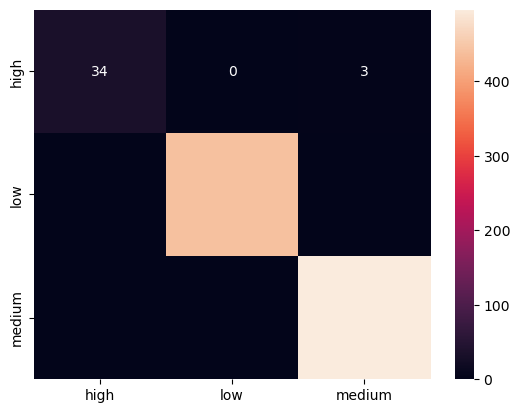

In [71]:
confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', ax=ax)
ax.xaxis.set_ticklabels(['high', 'low', 'medium'])
ax.yaxis.set_ticklabels(['high', 'low', 'medium'])

## Prediction

In [77]:
df = pd.read_csv('../data/processed/TWER_grouped_class.csv').drop('Unnamed: 0', axis=1)
df31 = df[df['day'] == 31]

In [78]:
df31

,date,municipality.name,hour_category,temperature,minTemperature,maxTemperature,precipitation,wind_speed,wind_dir,curr_cell,curr_site,population,elevation,tweet_count,month,day,day_of_week,class
4874,2013-12-31,Aldeno,B,4.400000,-0.2,5.0,0.0,2.5,13.0,4.387571,0.029447,3046.0,209.0,2,12,31,1,Medium
4875,2013-12-31,Aldeno,C,3.600000,-0.2,5.0,0.0,2.4,345.8,4.495938,0.030174,3046.0,209.0,5,12,31,1,Medium
4876,2013-12-31,Andalo,B,-0.228571,-3.6,2.6,0.0,NaN,NaN,0.000000,0.000000,1024.0,1042.0,7,12,31,1,Medium
4877,2013-12-31,Andalo,D,-2.325000,-3.6,2.6,0.0,NaN,NaN,0.000000,0.000000,1024.0,1042.0,4,12,31,1,Medium
4878,2013-12-31,Baselga di Pinè,B,0.600000,-4.0,4.2,0.0,NaN,NaN,13.159720,0.017180,4928.0,964.0,1,12,31,1,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,2013-12-31,Vigo di Fassa,B,-7.450000,-10.0,0.3,0.0,NaN,NaN,0.000000,0.000000,1219.0,1382.0,4,12,31,1,Medium
5029,2013-12-31,Vigo di Fassa,C,-3.966667,-10.0,0.3,0.0,NaN,NaN,0.000000,0.000000,1219.0,1382.0,3,12,31,1,Medium
5030,2013-12-31,Vigo di Fassa,D,-8.125000,-10.0,0.3,0.0,NaN,NaN,0.000000,0.000000,1219.0,1382.0,4,12,31,1,Medium
5031,2013-12-31,Villa Agnedo,C,0.533333,-3.3,4.9,0.0,NaN,NaN,9.225448,0.044170,994.0,356.0,3,12,31,1,Medium


In [281]:
X31 = df31.drop('class', axis=1)
y31 = df31['class']

In [282]:
X31

,date,municipality.name,hour_category,temperature,minTemperature,maxTemperature,precipitation,wind_speed,wind_dir,curr_cell,curr_site,population,elevation,tweet_count,month,day,day_of_week
4874,2013-12-31,Aldeno,B,4.400000,-0.2,5.0,0.0,2.5,13.0,4.387571,0.029447,3046.0,209.0,2,12,31,1
4875,2013-12-31,Aldeno,C,3.600000,-0.2,5.0,0.0,2.4,345.8,4.495938,0.030174,3046.0,209.0,5,12,31,1
4876,2013-12-31,Andalo,B,-0.228571,-3.6,2.6,0.0,NaN,NaN,0.000000,0.000000,1024.0,1042.0,7,12,31,1
4877,2013-12-31,Andalo,D,-2.325000,-3.6,2.6,0.0,NaN,NaN,0.000000,0.000000,1024.0,1042.0,4,12,31,1
4878,2013-12-31,Baselga di Pinè,B,0.600000,-4.0,4.2,0.0,NaN,NaN,13.159720,0.017180,4928.0,964.0,1,12,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,2013-12-31,Vigo di Fassa,B,-7.450000,-10.0,0.3,0.0,NaN,NaN,0.000000,0.000000,1219.0,1382.0,4,12,31,1
5029,2013-12-31,Vigo di Fassa,C,-3.966667,-10.0,0.3,0.0,NaN,NaN,0.000000,0.000000,1219.0,1382.0,3,12,31,1
5030,2013-12-31,Vigo di Fassa,D,-8.125000,-10.0,0.3,0.0,NaN,NaN,0.000000,0.000000,1219.0,1382.0,4,12,31,1
5031,2013-12-31,Villa Agnedo,C,0.533333,-3.3,4.9,0.0,NaN,NaN,9.225448,0.044170,994.0,356.0,3,12,31,1


In [283]:
categorical_features = ['date', 'municipality.name', 'hour_category', 'month', 'day_of_week']  # Any string or categorical features
numerical_features = ['temperature', 
                      'minTemperature', 
                      'maxTemperature', 
                      'precipitation', 
                      'wind_speed',
                      'wind_dir',
                      'curr_cell',
                      'population',
                      'elevation',
                      'curr_site',
                      'tweet_count',
                      'day']

In [284]:
le = LabelEncoder()
for feat in categorical_features:
    X31[feat] = le.fit_transform(X31[feat])

In [285]:
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(X31[numerical_features])

In [286]:
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_features)

In [287]:
X31[categorical_features].reset_index(drop=True)
#scaled_numerical_df.reset_index(drop=True)

,date,municipality.name,hour_category,month,day_of_week
0,0,0,1,0,0
1,0,0,2,0,0
2,0,1,1,0,0
3,0,1,3,0,0
4,0,2,1,0,0
...,...,...,...,...,...
154,0,74,1,0,0
155,0,74,2,0,0
156,0,74,3,0,0
157,0,75,2,0,0


In [288]:
X31 = pd.concat([scaled_numerical_df.reset_index(drop=True), X31[categorical_features].reset_index(drop=True).astype('category')], axis=1, ignore_index=True)

In [289]:
col_dict1 = {i: numerical_features[i] for i in range(len(numerical_features))}
col_dict2 = {i + len(numerical_features): categorical_features[i] for i in range(len(categorical_features))}
col_dict1.update(col_dict2)
col_dict1

{0: 'temperature',
 1: 'minTemperature',
 2: 'maxTemperature',
 3: 'precipitation',
 4: 'wind_speed',
 5: 'wind_dir',
 6: 'curr_cell',
 7: 'population',
 8: 'elevation',
 9: 'curr_site',
 10: 'tweet_count',
 11: 'day',
 12: 'date',
 13: 'municipality.name',
 14: 'hour_category',
 15: 'month',
 16: 'day_of_week'}

In [290]:
X31 = X31.rename(col_dict1, axis=1)

In [291]:
X31

,temperature,minTemperature,maxTemperature,precipitation,wind_speed,wind_dir,curr_cell,population,elevation,curr_site,tweet_count,day,date,municipality.name,hour_category,month,day_of_week
0,1.933044,2.064569,0.895625,0.0,2.269049,-1.922977,-0.265425,-0.161236,-1.700538,-0.248737,-0.451520,0.0,0,0,1,0,0
1,1.695303,2.064569,0.895625,0.0,2.116080,1.514819,-0.257824,-0.161236,-1.700538,-0.242781,-0.116567,0.0,0,0,2,0,0
2,0.557543,0.728234,0.043743,0.0,NaN,NaN,-0.573170,-0.271973,0.672589,-0.489875,0.106736,0.0,0,1,1,0,0
3,-0.065466,0.728234,0.043743,0.0,NaN,NaN,-0.573170,-0.271973,0.672589,-0.489875,-0.228218,0.0,0,1,3,0,0
4,0.803775,0.571019,0.611664,0.0,NaN,NaN,0.349855,-0.058165,0.450376,-0.349190,-0.563172,0.0,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,-1.588493,-1.787219,-0.772644,0.0,NaN,NaN,-0.573170,-0.261294,1.641213,-0.489875,-0.228218,0.0,0,74,1,0,0
155,-0.553330,-1.787219,-0.772644,0.0,NaN,NaN,-0.573170,-0.261294,1.641213,-0.489875,-0.339869,0.0,0,74,2,0,0
156,-1.789087,-1.787219,-0.772644,0.0,NaN,NaN,-0.573170,-0.261294,1.641213,-0.489875,-0.228218,0.0,0,74,3,0,0
157,0.783963,0.846146,0.860129,0.0,NaN,NaN,0.073904,-0.273616,-1.281751,-0.128172,-0.339869,0.0,0,75,2,0,0


In [292]:
y_pred31 = rf_classifier.predict(X31)

In [294]:
confusion_matrix(y31, y_pred31)

array([[ 3,  0,  2],
       [ 0, 59,  0],
       [ 0, 19, 76]])

[Text(0, 0.5, 'high'), Text(0, 1.5, 'low'), Text(0, 2.5, 'medium')]

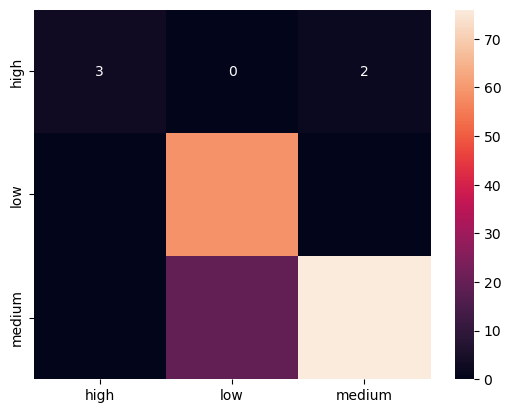

In [295]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(y31, y_pred31), annot=True, fmt='g', ax=ax)
ax.xaxis.set_ticklabels(['high', 'low', 'medium'])
ax.yaxis.set_ticklabels(['high', 'low', 'medium'])